# All imports necessary

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
from tqdm.autonotebook import tqdm

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
%matplotlib inline

# Auxiliary methods

In [4]:
def filter_by_subcorpus(data_root_folder, subcorpus_name):
    data_folders = [
        os.path.join(data_root_folder, folder, subfolder)
        for folder in tqdm(os.listdir(data_root_folder))
        for subfolder in os.listdir(os.path.join(data_root_folder, folder))
    ]
    mask = []
    for folder in tqdm(data_folders):
        with open(os.path.join(folder, 'en.met'), 'r', encoding='utf-8') as myfile:
            mask.append(subcorpus_name in myfile.read().replace('\n', ''))
    return np.array(data_folders)[mask]

In [5]:
def get_raw_texts(folders):
    texts = []
    for folder in tqdm(folders):
        with open(os.path.join(folder, 'en.raw'), 'r', encoding='utf-8') as myfile:
            texts.append(myfile.read().replace('\n', ''))
    return texts

In [6]:
def get_tagged_texts(folders):
    tagged_texts = []
    for folder in tqdm(folders):
        tagged_text = np.loadtxt(os.path.join(folder, 'en.tags'), dtype=str, delimiter='\t', encoding='utf-8')
        tagged_texts.append({
            'word': tagged_text[:, 0],
            'POS-tag': tagged_text[:, 1],
            'lemma': tagged_text[:, 2],
            'TARGET': tagged_text[:, 3]
        })
    return tagged_texts

# Read the data

In [7]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/data/', 'subcorpus: Voice of America')

In [8]:
raw_texts = get_raw_texts(target_subcorpus_folders)

In [9]:
tagged_texts = get_tagged_texts(target_subcorpus_folders)

# Gather a bit of statistics and draw a bit of plots

In [10]:
character_counts = list(map(len, tqdm(raw_texts)))

In [11]:
word_counts = list(map(lambda tagged_text: len(tagged_text['lemma']), tqdm(tagged_texts)))

In [12]:
word_sizes = [
    len(word)
    for text in tqdm(tagged_texts)
    for word in text['lemma']
]

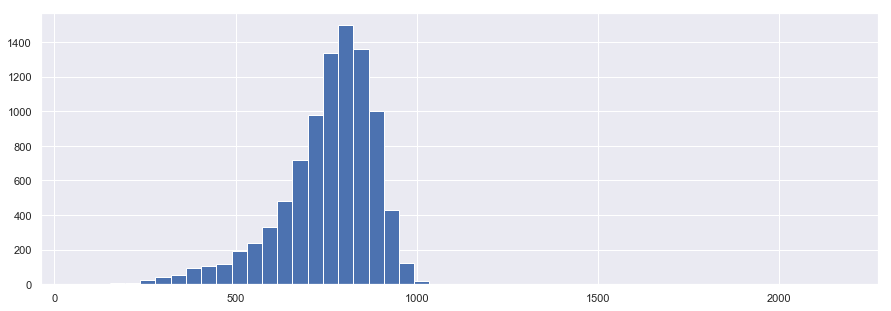

In [20]:
plt.figure(figsize=(15, 5))
plt.hist(character_counts, bins=50)
plt.show()

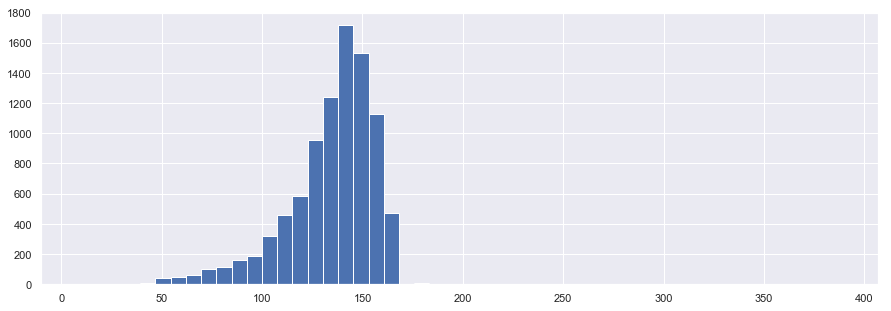

In [21]:
plt.figure(figsize=(15, 5))
plt.hist(word_counts, bins=50)
plt.show()

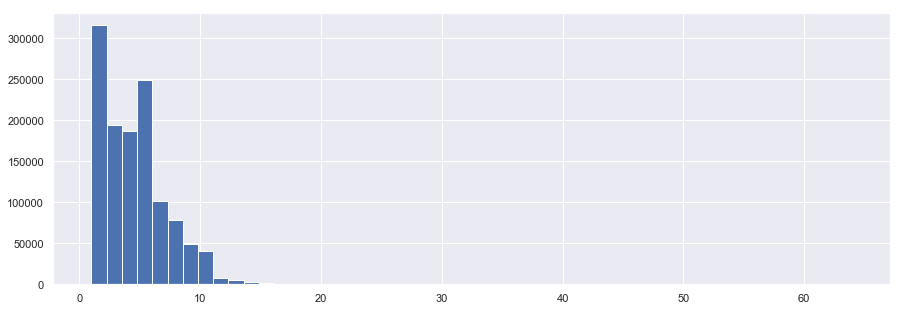

In [22]:
plt.figure(figsize=(15, 5))
plt.hist(word_sizes, bins=50)
plt.show()